RNN 알고리즘은 시계열 데이터 분석에도 활용 가능

주식 가격을 예측하거나 온도와 같은 기상 예측에 사용하는 것이 가능하다.

전력 거래소에서 발전소에서 전력을 구매할 때 지급하는 가격(SMP)을 시계열 데이터를 활용하여 예측하는 예제를 연습해보자


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random

SEED=12
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

from google.colab import drive, files
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
#전력 거래소 전력 거래가격(smp) 데이터
drive_path = "/gdrive/My Drive/"
smp_temp = pd.read_csv(drive_path + "smp/smp.csv", encoding='CP949') #한국어가 있어서 unicode decode error 없애주자

smp_temp.head(3)

,기간,01시,02시,03시,04시,05시,06시,07시,08시,09시,...,18시,19시,20시,21시,22시,23시,24시,최대,최소,가중평균
0,2020/03/31,81.79,80.44,80.60,80.45,80.59,80.73,80.80,84.47,85.93,...,83.70,84.18,84.66,82.83,82.02,82.02,82.02,87.25,80.44,83.41
1,2020/03/30,80.09,76.56,74.87,74.87,76.56,80.28,81.22,84.02,86.64,...,85.84,85.84,86.62,85.70,83.75,83.28,83.28,86.64,74.87,82.92
2,2020/03/29,82.48,82.54,82.38,78.93,79.22,81.52,81.52,81.52,78.66,...,82.10,82.07,83.57,82.09,81.90,80.92,81.02,83.57,76.39,80.30


In [3]:
smp = smp_temp.loc[:,['기간','최대','최소','가중평균']]

smp = smp.rename(columns={'기간':'date'})
smp = smp.rename(columns={'최대':'smp_max'})
smp = smp.rename(columns={'최소':'smp_min'})
smp = smp.rename(columns={'가중평균':'smp_mean'})
smp.head()

,date,smp_max,smp_min,smp_mean
0,2020/03/31,87.25,80.44,83.41
1,2020/03/30,86.64,74.87,82.92
2,2020/03/29,83.57,76.39,80.30
3,2020/03/28,82.93,78.99,81.63
4,2020/03/27,90.35,80.01,84.08


In [4]:
smp['date'] = pd.to_datetime(smp['date'])   #문자열 -> 날짜를 표시하는 datetime자료형
smp['day_of_week'] = smp['date'].dt.dayofweek #요일을 나타냄 0~6
print(smp.shape)
smp.head()

(821, 5)


,date,smp_max,smp_min,smp_mean,day_of_week
0,2020-03-31,87.25,80.44,83.41,1
1,2020-03-30,86.64,74.87,82.92,0
2,2020-03-29,83.57,76.39,80.30,6
3,2020-03-28,82.93,78.99,81.63,5
4,2020-03-27,90.35,80.01,84.08,4


In [5]:
smp = smp.sort_values(by='date')
smp.head()

,date,smp_max,smp_min,smp_mean,day_of_week
820,2018-01-01,95.93,73.69,84.88,0
819,2018-01-02,95.70,88.36,92.57,1
818,2018-01-03,96.47,88.37,92.34,2
817,2018-01-04,98.09,88.37,92.14,3
816,2018-01-05,96.12,88.23,92.42,4


In [6]:
#요일의 순서는 의미가 있으나 상대적인 크기는 의미가 없는 범주형 데이터
#원핫 인코딩 변환하여 딥러닝 모델에 입력하는 것이 좋은 결과를 얻을 수 있다.

smp['day_of_week'] = smp['day_of_week'].astype('category')
smp = pd.get_dummies(smp, columns = ['day_of_week'], prefix='W', drop_first=True)
smp.head()

,date,smp_max,smp_min,smp_mean,W_1,W_2,W_3,W_4,W_5,W_6
820,2018-01-01,95.93,73.69,84.88,0,0,0,0,0,0
819,2018-01-02,95.70,88.36,92.57,1,0,0,0,0,0
818,2018-01-03,96.47,88.37,92.34,0,1,0,0,0,0
817,2018-01-04,98.09,88.37,92.14,0,0,1,0,0,0
816,2018-01-05,96.12,88.23,92.42,0,0,0,1,0,0


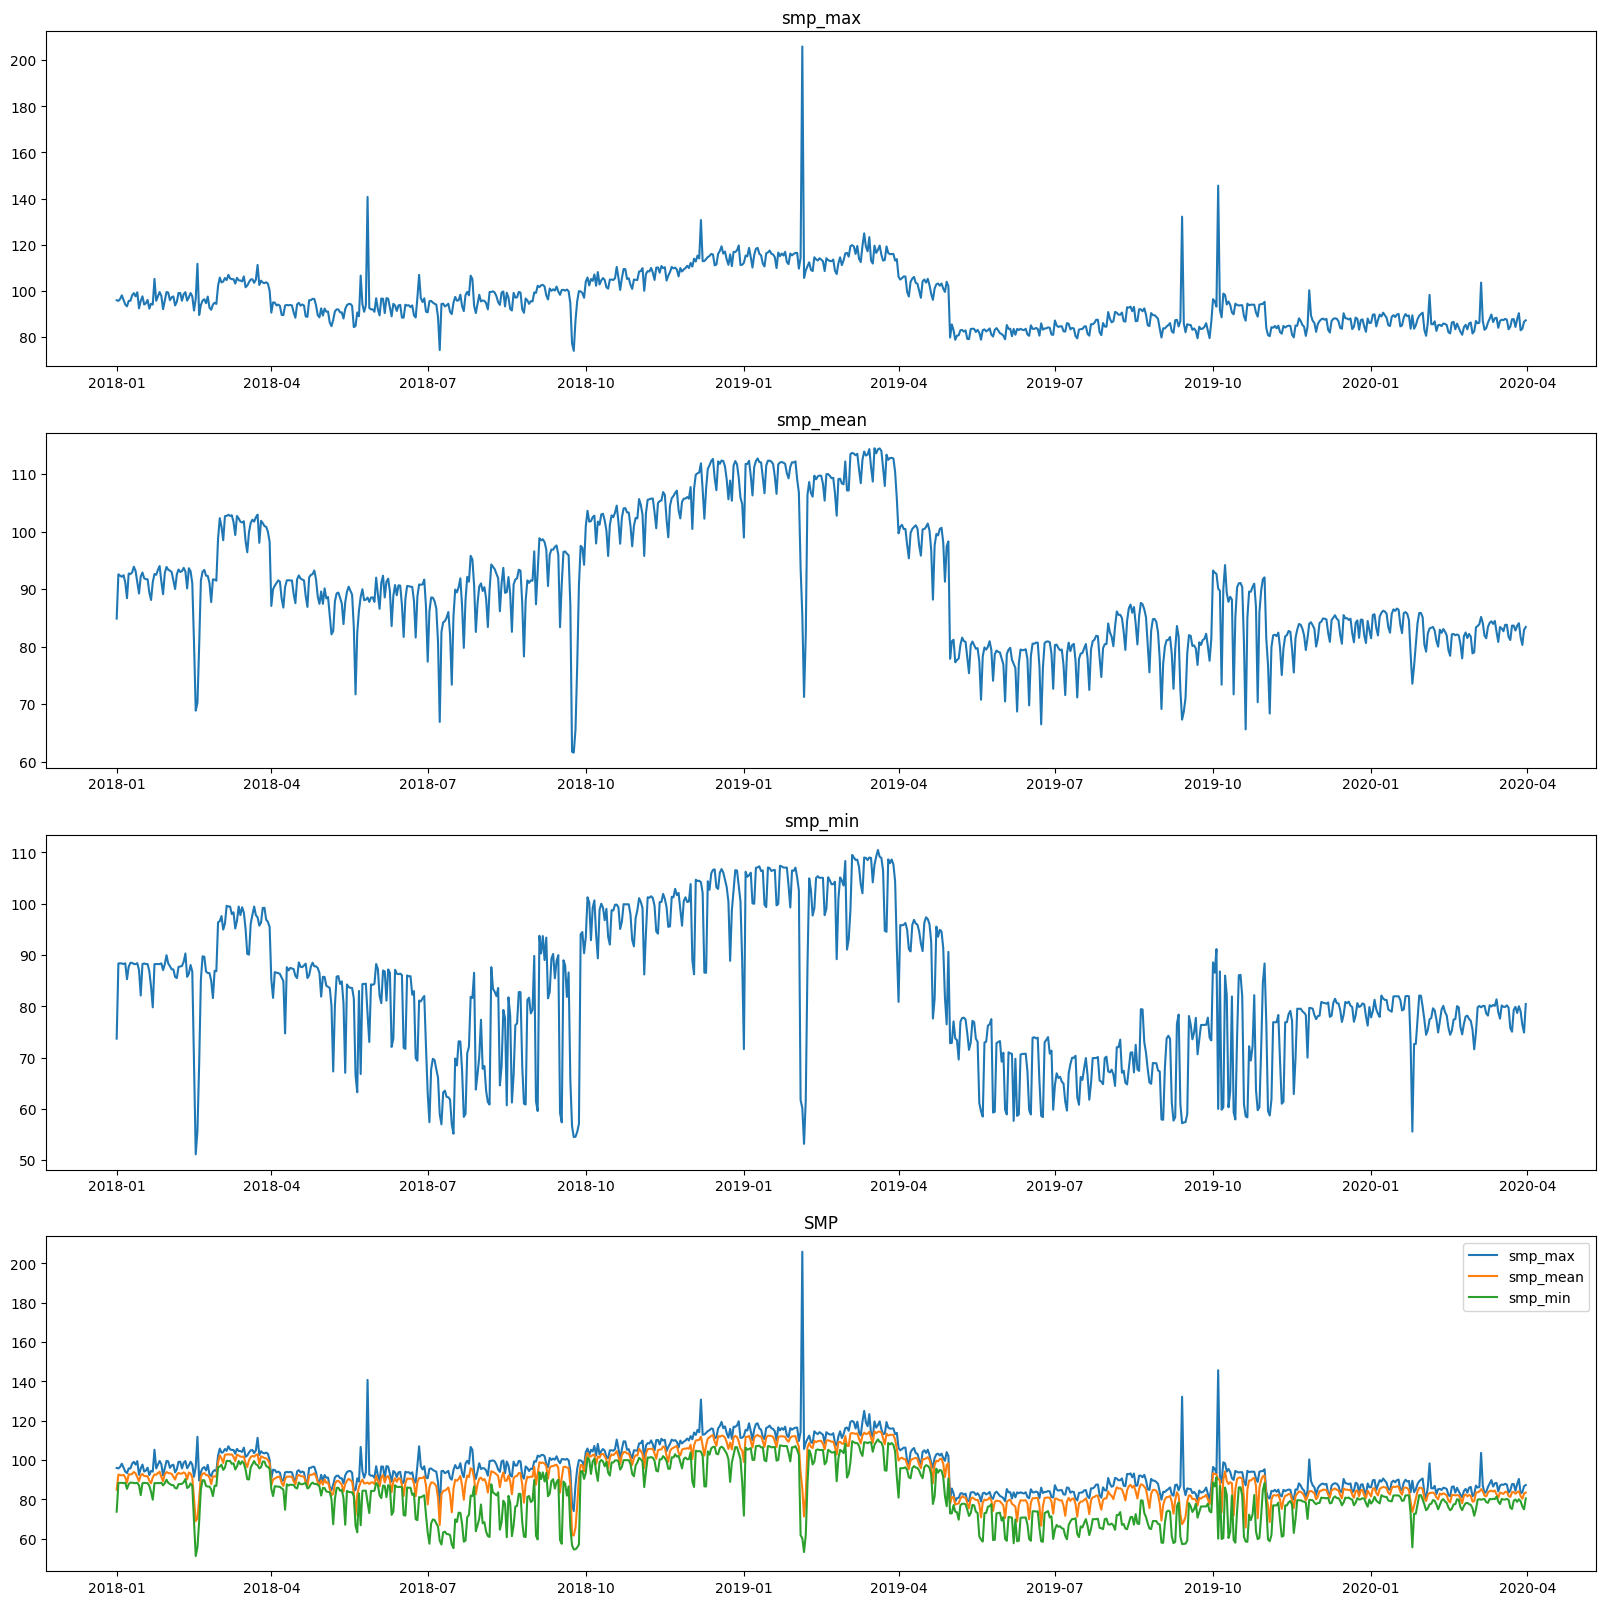

In [7]:
#전력 거래 가격을 나타내는 3개의 변수 smp_max, smp_mean, smp_min을 각각 그래프로 그려보자
#3개 변수를 하나의 그래프에 함께 출력해보자
#시계열 데이터의 일반적인 특징은 주기성 등을 확인할 수 있다.

fig, axes = plt.subplots(4,1, figsize=(20,20))

axes[0].plot(smp['date'], smp['smp_max'])
axes[0].set_title('smp_max')

axes[1].plot(smp['date'], smp['smp_mean'])
axes[1].set_title('smp_mean')

axes[2].plot(smp['date'], smp['smp_min'])
axes[2].set_title('smp_min')

axes[3].plot(smp['date'], smp['smp_max'], label = 'smp_max' )
axes[3].plot(smp['date'], smp['smp_mean'], label = 'smp_mean' )
axes[3].plot(smp['date'], smp['smp_min'], label = 'smp_min' )
axes[3].set_title('SMP')
axes[3].legend()

plt.show()
#smp_max와 smp_min의 경우 값이 매우 크거나 작은 이상치를 갖는 것을 확인할 수 있다.
#이상치를 검출하는 것보다는 장기적인 트렌드를 파악하는 것을 우선 목표로 설정한다.

#데이터 전처리

In [8]:
#2019년 12월 31일까지 데이터를 학습 데이터로 학습사용, 2020년 1월1일부터 이후 검증용으로 사용하자
#최근 10일 데이터를 학습하여 예측하는 날로부터 3일이 경과한 날의 SMP가격을 예측하는 모델을 만든다.
#과거 10일을 나타내는 window_size와 3일 후를 나타내는 future를 지정한다

#Settings
train_split_idx = 729 #2020.1.1 행 인덱스라 가정
window_size = 10  #과거 10일 동안 시계열 데이터를 학습 데이터로 사용
future = 3  #3일 이후의 타깃 예측

#Features
X_train = smp.iloc[:train_split_idx -window_size-future, 0:]
y_train = smp.iloc[window_size + future : train_split_idx, [3]] #'smp_mean' 열

print(X_train.shape, y_train.shape)

(716, 10) (716, 1)


맨위 10개가 입력 데이터 이걸로 훈련을 해서
그 밑에 3개(future) 다음 꺼의 smp_mean이 target이다.(즉 89.23 이 목표)
현재가 (10 index 일 때)

In [9]:
X_train.head(15)

,date,smp_max,smp_min,smp_mean,W_1,W_2,W_3,W_4,W_5,W_6
820,2018-01-01,95.93,73.69,84.88,0,0,0,0,0,0
819,2018-01-02,95.70,88.36,92.57,1,0,0,0,0,0
818,2018-01-03,96.47,88.37,92.34,0,1,0,0,0,0
817,2018-01-04,98.09,88.37,92.14,0,0,1,0,0,0
816,2018-01-05,96.12,88.23,92.42,0,0,0,1,0,0
815,2018-01-06,94.09,88.38,91.14,0,0,0,0,1,0
814,2018-01-07,93.31,85.28,88.42,0,0,0,0,0,1
813,2018-01-08,95.69,87.72,92.71,0,0,0,0,0,0
812,2018-01-09,95.71,88.48,92.61,1,0,0,0,0,0
811,2018-01-10,98.09,88.48,92.90,0,1,0,0,0,0


In [10]:
#첫번 째 타깃이 89.23이라 했는데
y_train.head()

,smp_mean
807,89.23
806,92.17
805,92.88
804,91.88
803,91.72


In [11]:
#X_test
test_start = train_split_idx - window_size - future #테스트 데이터 시작 행
test_end = smp.shape[0] - window_size - future
X_test = smp.iloc[test_start : test_end, 0:]

#y_test
y_test = smp.iloc[train_split_idx: , [3]]

print(X_test.shape, y_test.shape)

(92, 10) (92, 1)


In [12]:
X_test.head(15)

,date,smp_max,smp_min,smp_mean,W_1,W_2,W_3,W_4,W_5,W_6
104,2019-12-18,88.02,80.62,84.95,0,1,0,0,0,0
103,2019-12-19,87.62,80.90,84.64,0,0,1,0,0,0
102,2019-12-20,88.08,80.12,84.86,0,0,0,1,0,0
101,2019-12-21,83.45,79.85,82.37,0,0,0,0,1,0
100,2019-12-22,84.47,76.97,80.76,0,0,0,0,0,1
99,2019-12-23,88.43,78.22,84.16,0,0,0,0,0,0
98,2019-12-24,87.89,80.61,84.56,1,0,0,0,0,0
97,2019-12-25,83.20,79.87,81.53,0,1,0,0,0,0
96,2019-12-26,87.34,80.03,84.70,0,0,1,0,0,0
95,2019-12-27,87.69,80.56,84.66,0,0,0,1,0,0


In [13]:
#첫번째 target은 91행인 82.86이어야함
y_test.head()

#음 잘 매핑되어있군

,smp_mean
91,82.86
90,81.46
89,85.51
88,85.63
87,83.26


In [14]:
#딥러닝 모델의 성능을 확보하려면 피처 스케일링으로 전처리를 하는 것이 좋다.
#MinMaxScaler를 사용하여 입력 데이터를 0~1 범위로 정규화하자

#feature scaling
X_train_scaled = X_train.loc[:,'smp_max':]
X_test_scaled = X_test.loc[:,'smp_max':]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train_scaled.values)
X_train_scaled.loc[:,:] = scaler.transform(X_train_scaled.values)
X_test_scaled.loc[:,:] = scaler.transform(X_test_scaled.values)

#시계열 데이터를 미니 배치로 학습하려면 타임 스텝에 맞춰 배치 크기만큼 시계열 데이터를 묶어주는 작업이 필요하다

<ipython-input-14-fb1f77aa8aaf>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_train_scaled.loc[:,:] = scaler.transform(X_train_scaled.values)
<ipython-input-14-fb1f77aa8aaf>:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_test_scaled.loc[:,:] = scaler.transform(X_test_scaled.values)


In [15]:
#앞에서 정리한 입력 데이터x 와 목표 데이터y 배열을 입력하면
#타임 스텝을 하나씩 이동하면서 시계열의 길이(sequence_length)만큼 데이터를 그룹화한다.
#그리고 앞에서 만든 시계열 그룹을 배치 크기에 입력한 개수만큼 묶어서 미니 배치를 이룬다.

#Mini Batch 크기로 시계열 변환
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
train_data = timeseries_dataset_from_array(
    X_train_scaled, y_train, sequence_length=window_size, batch_size=16)
test_data = timeseries_dataset_from_array(
    X_test_scaled, y_test, sequence_length = window_size, batch_size = 16)

print(train_data)
print(test_data)

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 9), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 9), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


In [16]:
#배치 데이터셋 객체가 투플로 반환되는데
#입력 데이터는 (None, None, 9) 의 크기: (배치 크기, 시계열 길이, 피처 개수)
#목표 레이블은 (None, 1)의 형태: (배치 크기, 피처 개수)

for batch in test_data.take(1): #첫 번째 배치를 가져옴
  inputs, targets = batch

print("input: ", inputs.numpy().shape)
print("Target: ", targets.numpy().shape)
#10개 타임 스텝에 대한 9개 피처 데이터가 16개씩 하나의 배치를 이루는 것을 알 수 있다

input:  (16, 10, 9)
Target:  (16, 1)


In [17]:
inputs[0] #배치를 구성하는 16개의 데이터 중에서 첫 번째 데이터 (10 타임스텝, 9 피처) 형태

<tf.Tensor: shape=(10, 9), dtype=float64, numpy=
array([[0.10612492, 0.49688395, 0.44167139, 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.10309278, 0.50160013, 0.43581017, 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        ],
       [0.10657975, 0.48846219, 0.43996975, 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        ],
       [0.07148272, 0.48391443, 0.39289091, 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        ],
       [0.07921468, 0.43540509, 0.36245037, 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        ],
       [0.10923287, 0.45645949, 0.42673473, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.10513948, 0.49671551, 0.4342976 , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.06958763, 0.48425131, 0.37700889, 0.        , 1.        ,
        

In [18]:
targets[0]  #목표 레이블 배치의 16개 원소 중에서 첫 번째 값은 82.86이다.

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([82.86])>

#LSTM 모델로 시계열 예측

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense

model = Sequential()
model.add(Input(shape=[10,9]))

model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(units=1, activation = 'linear'))

model.compile(optimizer='adam',
              loss = 'mse',
              metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5376      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5409 (21.13 KB)
Trainable params: 5409 (21.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


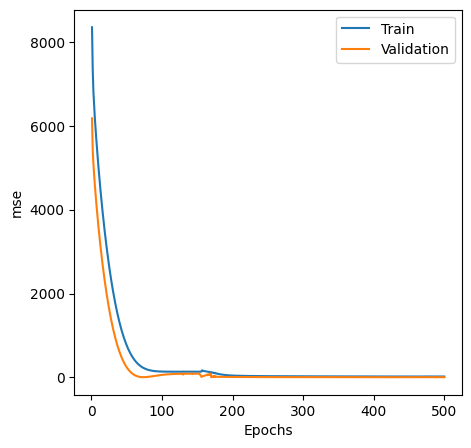

In [20]:
history = model.fit(train_data, epochs=500,
                    validation_data = test_data,
                    verbose=0)
def plot_loss_curve(history, total_epoch = 10, start = 1):
  plt.figure(figsize=(5,5))
  plt.plot(range(start, total_epoch+1),
           history.history['loss'][start-1:total_epoch],
           label='Train')
  plt.plot(range(start, total_epoch+1),
           history.history['val_loss'][start-1:total_epoch],
           label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('mse')
  plt.legend()
  plt.show()
plot_loss_curve(history = history, total_epoch=len(history.history['loss']), start=1)

In [21]:
y_pred = model.predict(test_data)
y_pred.shape

6/6 [==============================] - 0s 4ms/step


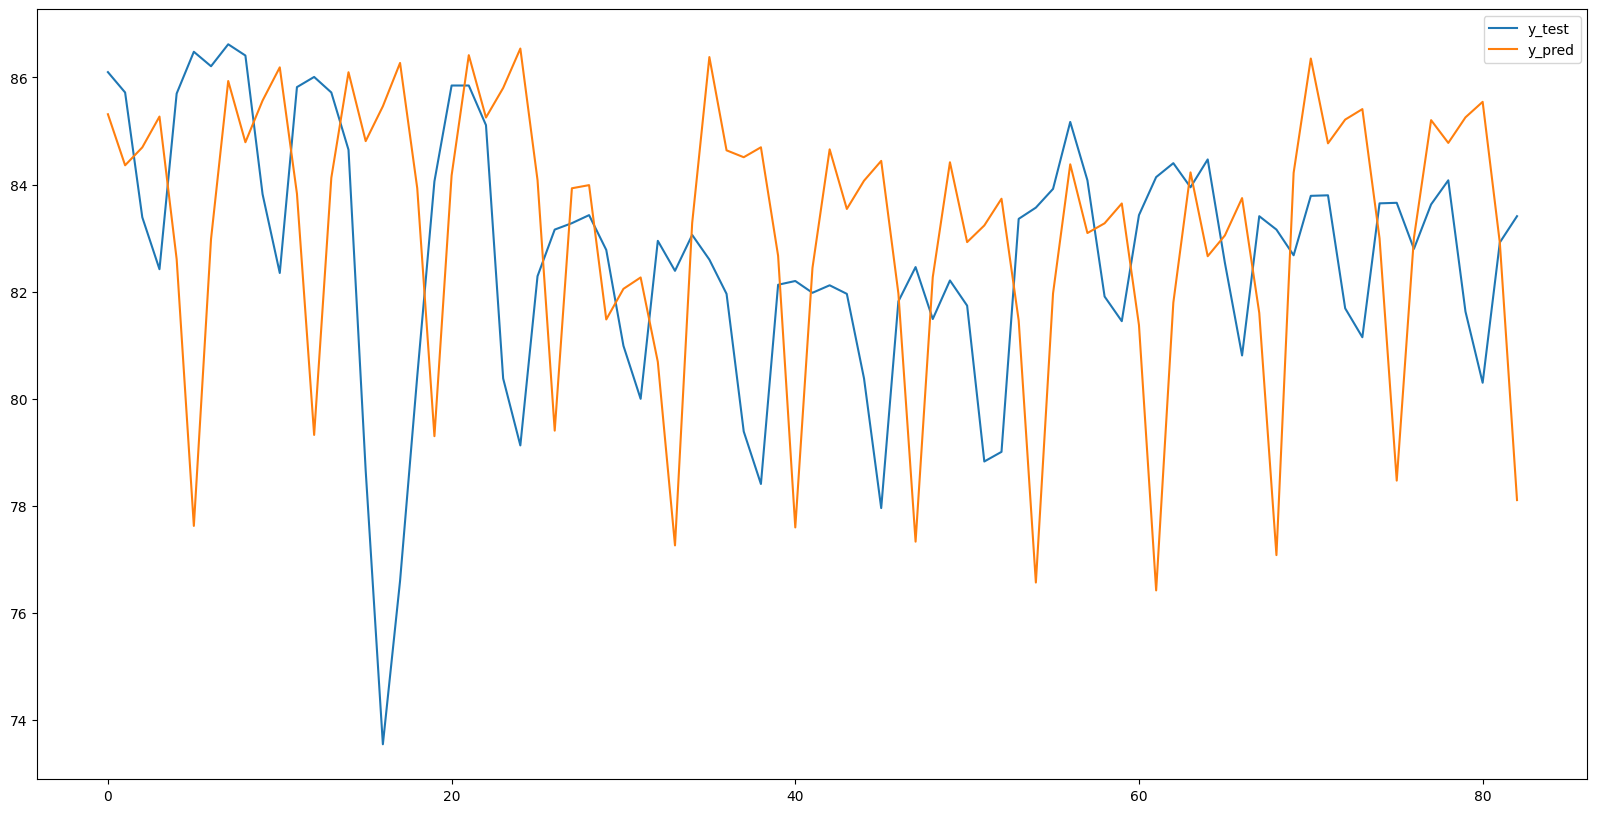

In [22]:
plt.figure(figsize=(20,10))
plt.plot(range(len(y_pred)), y_test[window_size-1:],label='y_test' )
plt.plot(range(len(y_pred)), y_pred, label = 'y_pred')
plt.legend()
plt.show()